In [1]:
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

import numpy as np
import matplotlib.pyplot as plt
# Plotly
import plotly.plotly as py
import plotly.tools as tls
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import time
import tensorflow as tf

In [2]:
name = '0700.HK'
filename = 'daily_{}'.format(name)
df = pd.read_csv('dataset/{}.csv'.format(filename))
df = df.dropna()

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d').sort_values(ascending=True)
date = df['Date']
# date = df['Date'].map(datetime.datetime.toordinal)

valid_set_size_percentage = 10 
test_set_size_percentage = 10 

df = df.iloc[:, 4:5].values

# date = np.array(date)
# (-1,1) unknown row, 1 column
date = date.values
date = date.reshape(-1,1)



In [3]:
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df)
len(df)


2471

In [4]:
valid_set_size = int(np.round(valid_set_size_percentage/100*len(df)));  
test_set_size = int(np.round(test_set_size_percentage/100*len(df)));
train_set_size = len(df) - (valid_set_size + test_set_size);
  
training_set_scaled = df_scaled[:train_set_size]
valid_set_scaled = df_scaled[train_set_size:train_set_size+valid_set_size]
test_set_scaled = df_scaled[train_set_size+valid_set_size:]

real_stock_price = df[train_set_size+valid_set_size:]
real_stock_price = real_stock_price[60:]

date_predict = date[train_set_size+valid_set_size+60:]
print(date_predict)

print(training_set_scaled.shape)

[['2018-07-18T00:00:00.000000000']
 ['2018-07-19T00:00:00.000000000']
 ['2018-07-20T00:00:00.000000000']
 ['2018-07-23T00:00:00.000000000']
 ['2018-07-24T00:00:00.000000000']
 ['2018-07-25T00:00:00.000000000']
 ['2018-07-26T00:00:00.000000000']
 ['2018-07-27T00:00:00.000000000']
 ['2018-07-30T00:00:00.000000000']
 ['2018-07-31T00:00:00.000000000']
 ['2018-08-01T00:00:00.000000000']
 ['2018-08-02T00:00:00.000000000']
 ['2018-08-03T00:00:00.000000000']
 ['2018-08-06T00:00:00.000000000']
 ['2018-08-07T00:00:00.000000000']
 ['2018-08-08T00:00:00.000000000']
 ['2018-08-09T00:00:00.000000000']
 ['2018-08-10T00:00:00.000000000']
 ['2018-08-13T00:00:00.000000000']
 ['2018-08-14T00:00:00.000000000']
 ['2018-08-15T00:00:00.000000000']
 ['2018-08-16T00:00:00.000000000']
 ['2018-08-17T00:00:00.000000000']
 ['2018-08-20T00:00:00.000000000']
 ['2018-08-21T00:00:00.000000000']
 ['2018-08-22T00:00:00.000000000']
 ['2018-08-23T00:00:00.000000000']
 ['2018-08-24T00:00:00.000000000']
 ['2018-08-27T00:00:

In [5]:
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []

# LSTMs expect our data to be in a specific format, 
# usually a 3D array. We start by creating data in 60 timesteps 
# and converting it into an array using NumPy.
# Next, we convert the data into a 3D dimension array with X_train samples, 
# 60 timestamps, and one feature at each step.
    
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
for i in range(60, len(valid_set_scaled)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0])
    
for i in range(60, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i, 0])
    y_test.append(test_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test, y_test = np.array(X_test), np.array(y_test)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape,X_valid.shape,X_test.shape)


(1917, 60, 1) (187, 60, 1) (187, 60, 1)


In [6]:
regressor = Sequential()

# units means that how many output nodes of dense layer should be returned.
# Because the fully connected layer(dense layer) should consist of input and output.
# Then , the mean of dimensionality of the output space could be translated to the number of ouput nodes.

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

finishTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(finishTime))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 20, batch_size = 32,validation_data=[X_valid,y_valid],callbacks=[tb_callback])

Train on 1917 samples, validate on 187 samples
Epoch 1/20
  32/1917 [..............................] - ETA: 1:28 - loss: 0.0394 - accuracy: 0.0000e+00

W0422 17:25:29.274671 4805342656 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (1.829091). Check your callbacks.


1917/1917 [==============================] - 15s 8ms/sample - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0053
Epoch 2/20
1917/1917 [==============================] - 9s 5ms/sample - loss: 6.4056e-04 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0053
Epoch 3/20
1917/1917 [==============================] - 9s 5ms/sample - loss: 5.6178e-04 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0053
Epoch 4/20
1917/1917 [==============================] - 11s 6ms/sample - loss: 5.2269e-04 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 0.0053
Epoch 5/20
1917/1917 [==============================] - 13s 7ms/sample - loss: 4.9369e-04 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0053
Epoch 6/20
1917/1917 [==============================] - 11s 6ms/sample - loss: 4.3649e-04 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0053
Epoch 7/20
1917/1917 [==============================] - 9s 4ms/sample - loss: 4.4621e-0

In [7]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)
print(real_stock_price.shape)

(187, 1)
(187, 1)


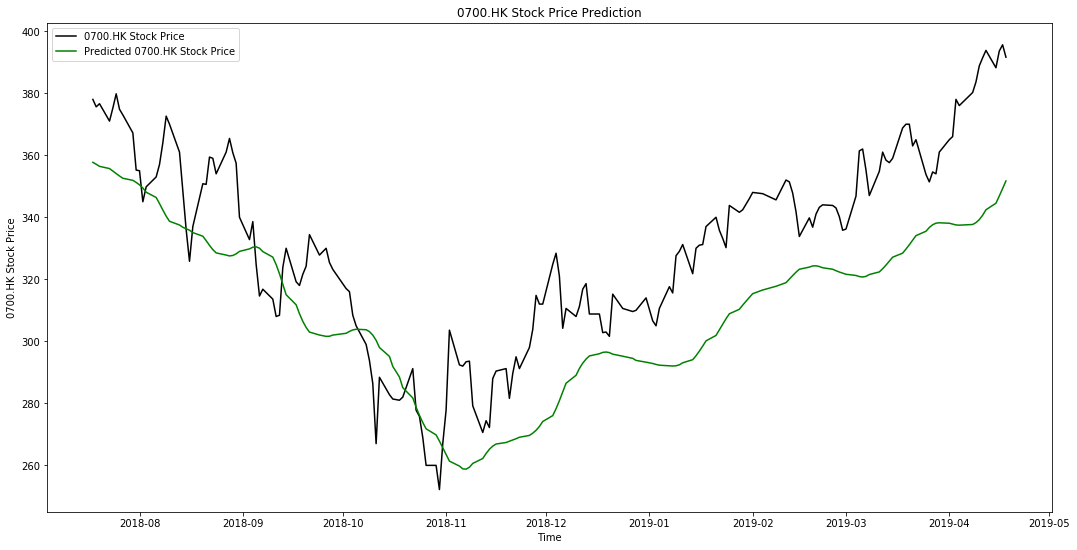

In [15]:
fig = plt.figure(figsize = (18,9))
plt.plot(date_predict,real_stock_price, color = 'black', label = '{} Stock Price'.format(name))
plt.plot(date_predict,predicted_stock_price, color = 'green', label = 'Predicted {} Stock Price'.format(name))
plt.title('{} Stock Price Prediction'.format(name))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(name))
plt.legend()
plt.show()

In [ ]:
finishTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

In [13]:
regressor.save('trained_model/model/{}_model_{}.h5'.format(name,finishTime))  # creates a HDF5 file 'my_model.h5'
# 將參數儲存至 HDF5 檔案（不含模型）
regressor.save_weights('trained_model/model_weight/{}_model_weights_{}.h5'.format(name,finishTime))

In [17]:
fig.savefig('img/{}_{}.png'.format(name,finishTime))

In [21]:
# Converting to Plotly's Figure object..
# plotly_fig = tls.mpl_to_plotly(fig)
plotly_fig = py.plot_mpl(fig, filename="my first plotly plot")